In [22]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tqdm import tqdm

# set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

from utils import *
from gen import test, random_search, true_random_search, true_random_nsteps


In [5]:
env = gym.make(
    "MiniHack-ExploreMaze-Hard-Mapped-v0",
    observation_keys=("chars", "pixel"),
    #des_file = "simple_maze.des",
    max_episode_steps=10000
)
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---         ----          ---                                                   
|.           .>            .|                                                   
|.............. ....... ....|                                                   
|.. .       ...   .     . ..|                                                   
|.. ....... ... ... ..... ..|                                                   
|.    .   . ... . . .     ..|                                                   
|.... ... . ... . . ... ....|                                                   
|....   . . ... .     . . ..|                                                   
|.. ..... . ... ..... . . .

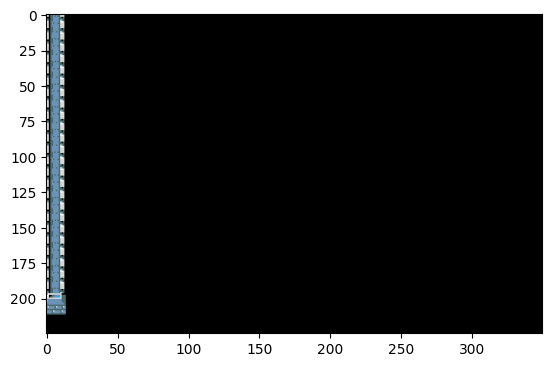

In [6]:
plt.imshow(state['pixel'][75:300, 450:800])

In [7]:
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

In [8]:
test()

test


In [9]:
path1 = random_search(game_map, start, target)
len(path1)

Target found!
target (4, 14)
target (4, 13)
target (5, 13)
target (5, 12)
target (5, 11)
target (5, 10)
target (5, 9)
target (5, 8)
target (5, 7)
target (5, 6)
target (5, 5)
target (5, 4)
target (5, 3)
target (5, 2)
target (5, 1)
target (6, 1)
target (7, 1)
target (8, 1)
target (9, 1)
target (10, 1)
target (11, 1)
target (12, 1)
target (13, 1)
target (14, 1)
target (15, 1)
target (16, 1)


26

In [10]:
path = true_random_nsteps(game_map, start, target)
len(path)

101

In [11]:
path

[(16, 1),
 (15, 1),
 (14, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (14, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (14, 1),
 (13, 1),
 (12, 1),
 (11, 1),
 (10, 1),
 (9, 1),
 (10, 1),
 (9, 1),
 (9, 2),
 (9, 1),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (12, 1),
 (13, 1),
 (13, 2),
 (13, 3),
 (13, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (14, 1),
 (15, 1),
 (15, 2),
 (15, 3),
 (15, 4),
 (15, 5),
 (15, 6),
 (14, 6),
 (13, 6),
 (14, 6),
 (15, 6),
 (15, 7),
 (15, 6),
 (14, 6),
 (13, 6),
 (14, 6),
 (15, 6),
 (14, 6),
 (15, 6),
 (14, 6),
 (15, 6),
 (15, 5),
 (15, 4),
 (15, 3),
 (15, 4),
 (15, 5),
 (15, 4),
 (15, 5),
 (15, 6),
 (15, 7),
 (15, 8),
 (15, 7),
 (15, 8),
 (15, 7),
 (15, 8),
 (14, 8),
 (13, 8),
 (14, 8),
 (13, 8),
 (14, 8),
 (13, 8),
 (14, 8),
 (13, 8),
 (14, 8),
 (15, 8),
 (14, 8),
 (15, 8),
 (14, 8),
 (13, 8),
 (13, 9),
 (13, 10),
 (12, 10),
 (11, 10),
 (10, 10),
 (9, 10),
 (8, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10),
 (9, 10),
 (8, 10),
 (7, 10),
 (8, 10),
 (7, 10),
 (8, 10),
 (7, 10),
 (8, 10),


In [12]:
# print last element of path
path[-1]

(9, 10)

In [13]:
target

(4, 14)

In [ ]:
def crossover(path1, path2):
    """Crossover two paths"""
    # find the first index where the paths differ
    for i in range(len(path1)):
        if path1[i] != path2[i]:
            break
    # return the crossover path
    return path1[:i] + path2[i:]


def mutate(path, n_mutations=1):
    """Mutate a path"""
    # select n positions to mutate
    idxs = np.random.choice(len(path), n_mutations, replace=False)

    # replace the positions with random actions
    # we need a list of actions to choose from
    new_path = np.random.choice(list(ACTION_LOOKUP.keys()), n_mutations)
    # replace the actions at idxs with new_path
    for idx, action in zip(idxs, new_path):
        path[idx] = action
    
    return path


In [32]:
# this is manhattan distance from the last element of the path to the target
fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

MAX_GENERATIONS = 100
MAX_INDIVIDUALS = 100

scores =[]

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [true_random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]

# create a list of tuples (individual, fitness)
print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS), postfix='Generation'):
    generation_scores = []
    generation_scores.append(min(fitnesses))
    fitnesses = [fitness_function(individual) for individual in individuals]

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    
    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.
    best_individuals = population[:2]

    # create a new generation
    new_individuals = []


actions = best_individuals[0][0]

#best_path

> Creating initial population...
> Evolving...


100%|██████████| 100/100 [00:00<00:00, 22361.27it/s, Generation]


In [17]:
"""image = plt.imshow(game[75:300, 450:800])

for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][75:300, 450:800])"""

"image = plt.imshow(game[75:300, 450:800])\n\nfor action in actions:\n    s, _, _, _ = env.step(action)\n    display.display(plt.gcf())\n    display.clear_output(wait=True)\n    image.set_data(s['pixel'][75:300, 450:800])"

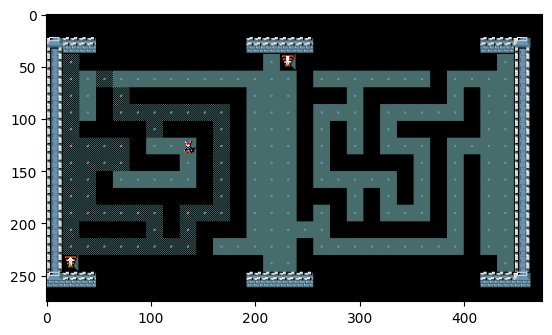

In [26]:
image = plt.imshow(game[25:300, :475])
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][25:300, :475])